In [1]:
%matplotlib inline

In [2]:
from skimage import color, io, measure, img_as_ubyte
from skimage.measure import profile_line
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom

plt.ion()

In [3]:
import math
from typing import Sequence, Optional, Dict, Any, Tuple

def plot_images_grid(
    images: Sequence[np.ndarray],
    titles: Optional[Sequence[Optional[str]]] = None,
    args: Optional[Dict[str, Any]] = None,
) -> Tuple[plt.Figure, np.ndarray]:
    """
    Plot images in a grid with at most 3 columns, expanding rows as needed.

    Layout examples (r x c):
      1 image  -> 1x1  (fills [0,0])
      2 images -> 1x2  (fills [0,0],[0,1])
      3 images -> 1x3  (fills [0,0],[0,1],[0,2])
      4 images -> 2x3  (fills [0,0],[0,1],[0,2],[1,0])
      5 images -> 2x3  (fills [0,0],[0,1],[0,2],[1,0],[1,1])
      6 images -> 2x3  (fills [0,0],[0,1],[0,2],[1,0],[1,1],[1,2])
      7 images -> 3x3  (fills [0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0])
      ...and so on.

    Parameters
    ----------
    images : Sequence[np.ndarray]
        Each image is a NumPy array (e.g., from skimage.io.imread) with dtype uint8.
        Grayscale (H,W), RGB (H,W,3), or RGBA (H,W,4) are supported.
    titles : Optional[Sequence[Optional[str]]]
        Per-image titles. If fewer than images, remaining images have no title.
    args : Optional[Dict[str, Any]]
        Keyword arguments applied to every image. These are passed to `imshow`.
        Special key:
          - 'axis': value passed to `ax.axis(...)` for every subplot (default 'off').

    Returns
    -------
    (fig, axes) : (matplotlib.figure.Figure, np.ndarray)
        The created Figure and a 2D array of Axes (shape: rows x cols).
    """
    images = list(images)
    n = len(images)
    if n == 0:
        raise ValueError("No images provided.")
    if titles is None:
        titles = []
    else:
        titles = list(titles)

    # Grid with at most 3 columns, expanding rows
    cols = min(3, n)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, squeeze=False, figsize=(cols * 4, rows * 4))

    # Prepare kwargs
    imshow_kwargs = dict(args) if isinstance(args, dict) else {}
    axis_setting = imshow_kwargs.pop("axis", "off")

    for i, img in enumerate(images):
        r, c = divmod(i, cols)
        ax = axes[r, c]

        # Default to grayscale colormap if 2D or single-channel and no cmap provided
        if (img.ndim == 2 or (img.ndim == 3 and img.shape[2] == 1)) and "cmap" not in imshow_kwargs:
            imshow_kwargs_with_cmap = {**imshow_kwargs, "cmap": "gray"}
        else:
            imshow_kwargs_with_cmap = imshow_kwargs

        ax.imshow(img, **imshow_kwargs_with_cmap)

        if i < len(titles) and titles[i] is not None:
            ax.set_title(str(titles[i]))
        ax.axis(axis_setting)

    # Hide any unused axes (when rows*cols > n)
    for j in range(n, rows * cols):
        r, c = divmod(j, cols)
        axes[r, c].set_visible(False)

    fig.tight_layout()
    return fig, axes


# Exercise 1

In [4]:
im_org = io.imread("vertebra.png")
im_uint8 = im_org.astype(np.uint8)

print(im_org.shape)

(998, 800)


Text(0.5, 1.0, 'Histogram')

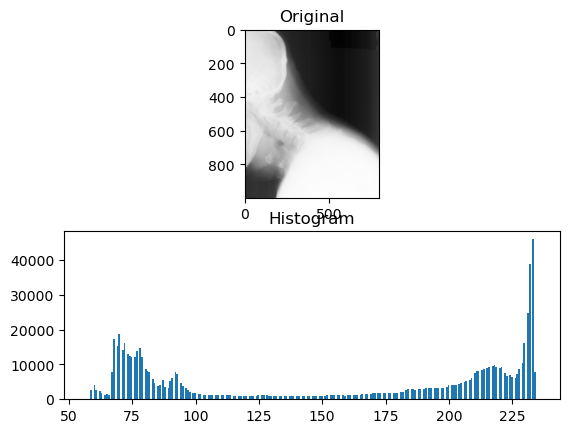

In [5]:
fig, ax = plt.subplots(2, 1)
ax[0].imshow(im_org, cmap='gray')
ax[0].set_title("Original")
ax[1].hist(im_org.ravel(), bins=256)
ax[1].set_title("Histogram")

The bones do show a more grayish color, perhaps in the range 200-225, while the torso is at the peaking ranges above 225 and soft tissue seems to be in ranges in between. My experience is that it's actually quite hard to fully segment only the bones based only on pixel values, although it seems quite intuitive.

In [6]:
print(im_org.shape)

(998, 800)


# Exercise 2

In [7]:
print("Min:", imin:=np.min(im_org))
print("Max:", imax:=np.max(im_org))

Min: 57
Max: 235


Yes it is possible to enhance the appearance, although the results may not be noticable. We can shift the pixel values and expand/interpolate ranging from 0-255.

Text(0.5, 1.0, 'Interpolated histogram')

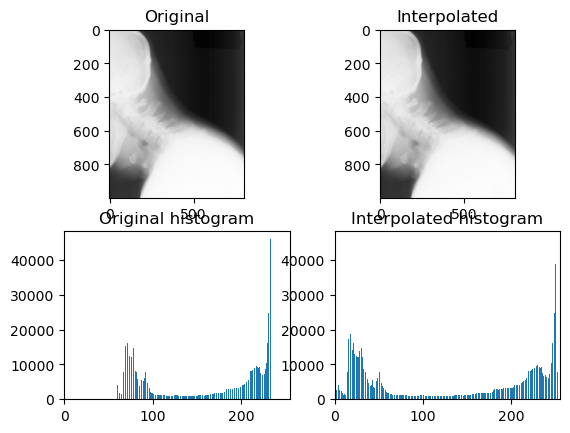

In [8]:
out = np.interp(im_org, (imin, imax), (0, 255)).astype(np.uint8)
# plt.imshow(out, cmap='gray')

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(im_org, cmap='gray')
ax[0, 0].set_title("Original")
ax[0, 1].imshow(out, cmap='gray')
ax[0, 1].set_title("Interpolated")

ax[1, 0].hist(im_org.ravel(), bins=256)
ax[1, 0].set_title("Original histogram")
ax[1, 0].set_xlim(xmin=0, xmax=255)
ax[1, 1].hist(out.ravel(), bins=256)
ax[1, 1].set_xlim(xmin=0, xmax=255)
ax[1, 1].set_title("Interpolated histogram")


# Exercise 3

In [9]:
from skimage.util import img_as_float
from skimage.util import img_as_ubyte

In [10]:
im_org = io.imread("vertebra.png")
print((im_org.min(), im_org.max())) # Normally a ubyte
im_u = img_as_ubyte(im_org)
im_f = img_as_float(im_org)
print((im_u.min(), im_u.max()))
print((im_f.min(), im_f.max()))

(np.uint8(57), np.uint8(235))
(np.uint8(57), np.uint8(235))
(np.float64(0.22352941176470587), np.float64(0.9215686274509803))


In [11]:
print((im_f.min()*255, im_f.max()*255))

(np.float64(56.99999999999999), np.float64(235.0))


Thus it is indeed the ubyte represented as a float which was divided by 255.

# Exercise 4

In [12]:
im_fu=img_as_ubyte(im_f)
print((im_fu.min(), im_fu.max()))

(np.uint8(57), np.uint8(235))


I actually expected the float to be floored when converted to uint8 (ubyte), but it seems that skimage rounds to the nearest. In terms of representing the image as a ubyte, the conversion from ubyte to float to ubyte again, is as expected; it does not lose information.

# Exercise 5

In [13]:
def histogram_stretch(img_in):
    """
    Stretches the histogram of an image 
    :param img_in: Input image
    :return: Image, where the histogram is stretched so the min values is 0 and the maximum value 255
    """
    # img_as_float will divide all pixel values with 255.0
    img_float = img_as_float(img_in)
    min_val = img_float.min()
    max_val = img_float.max()
    min_desired = 0.0
    max_desired = 1.0
	
    img_out = min_desired + (img_float - min_val) * (max_desired - min_desired)/(max_val - min_val)

    # img_as_ubyte will multiply all pixel values with 255.0 before converting to unsigned byte
    return img_as_ubyte(img_out)

# Exercise 6

Text(0.5, 1.0, 'Histogram stretch')

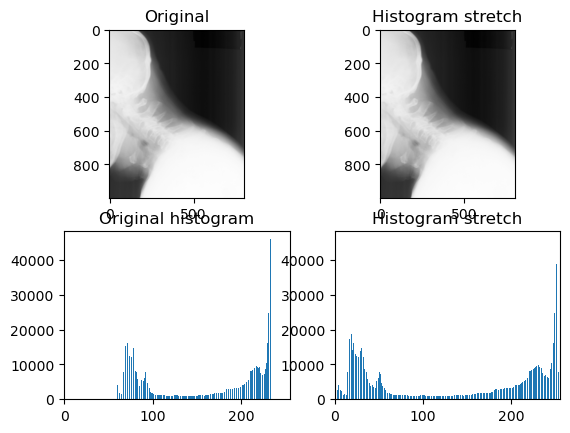

In [14]:
im_org = io.imread("vertebra.png")
out = histogram_stretch(im_org)

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(im_org, cmap='gray')
ax[0, 0].set_title("Original")
ax[0, 1].imshow(out, cmap='gray')
ax[0, 1].set_title("Histogram stretch")

ax[1, 0].hist(im_org.ravel(), bins=256)
ax[1, 0].set_title("Original histogram")
ax[1, 0].set_xlim(xmin=0, xmax=255)
ax[1, 1].hist(out.ravel(), bins=256)
ax[1, 1].set_xlim(xmin=0, xmax=255)
ax[1, 1].set_title("Histogram stretch")

We reached identical results to the numpy interpolation by calculating the stretching ourselves. It seems like nothing happens visually, but the pixel values are more spread out, perhaps enabling us to capture pixel groups more efficiently.

# Exercise 7

In [68]:
%matplotlib tk

In [16]:
from matplotlib.widgets import Slider, Button

# --- gamma helper ---
def gamma_map(img, gamma=1.0):
    """Apply gamma correction to img (grayscale or RGB)."""
    x = img.astype(np.float32)
    # normalize to [0,1] based on the image's min/max
    x_min, x_max = x.min(), x.max()
    if x_max > x_min:
        x = (x - x_min) / (x_max - x_min)
    # apply gamma (use 1/gamma convention)
    y = np.power(np.clip(x, 0, 1), 1.0 / float(gamma))
    return (y * 255.0).astype(np.uint8)

In [17]:
def gamma_map(img, gamma):
    f = img_as_float(img)
    g = np.power(f, gamma)
    return img_as_ubyte(g)

In [ ]:
if False:
    im_org = io.imread("vertebra.png")
    im_g = gamma_map(im_org, gamma=10)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plt.subplots_adjust(bottom=0.22)  # make room for the sliderax[0].imshow(im_org, cmap='gray')

    im0 = ax[0].imshow(im_org, cmap='gray')
    ax[0].set_title("Original")
    ax[0].axis('off')

    im1 = ax[1].imshow(im_g, cmap='gray')
    ax[1].set_title("Gamma mapped image")
    ax[1].axis('off')

    # --- slider (left, bottom, width, height) in figure coordinates ---
    ax_gamma = plt.axes([0.15, 0.08, 0.7, 0.04])
    gamma_slider = Slider(
        ax=ax_gamma, label="Gamma",
        valmin=0.1, valmax=45.0, valinit=10.0, valstep=0.1
    )

    # optional reset button
    ax_reset = plt.axes([0, 0.08, 0.08, 0.04])
    btn_reset = Button(ax_reset, "Reset")

    # --- interaction ---
    def on_gamma_change(val):
        g = gamma_slider.val
        im1.set_data(gamma_map(im_org, gamma=g))
        fig.canvas.draw_idle()

    gamma_slider.on_changed(on_gamma_change)
    btn_reset.on_clicked(lambda event: gamma_slider.reset())

    plt.show()


We need to be careful not to lose information when increasing gamma. Increasing gamma makes the soft tissue disappear, but we also lose the outer pixels of the bones; a balance is needed.

In [70]:
%matplotlib inline

# Exercise 9

In [58]:
from skimage.color import rgb2gray

def threshold_image(img_in, thres):
    """
    Apply a threshold in an image and return the resulting image
    :param img_in: Input image
    :param thres: The treshold value in the range [0, 255]
    :return: Resulting image (unsigned byte) where background is 0 and foreground is 255
    """
    im = img_as_ubyte(img_in)
    mask = im >= thres
    return mask

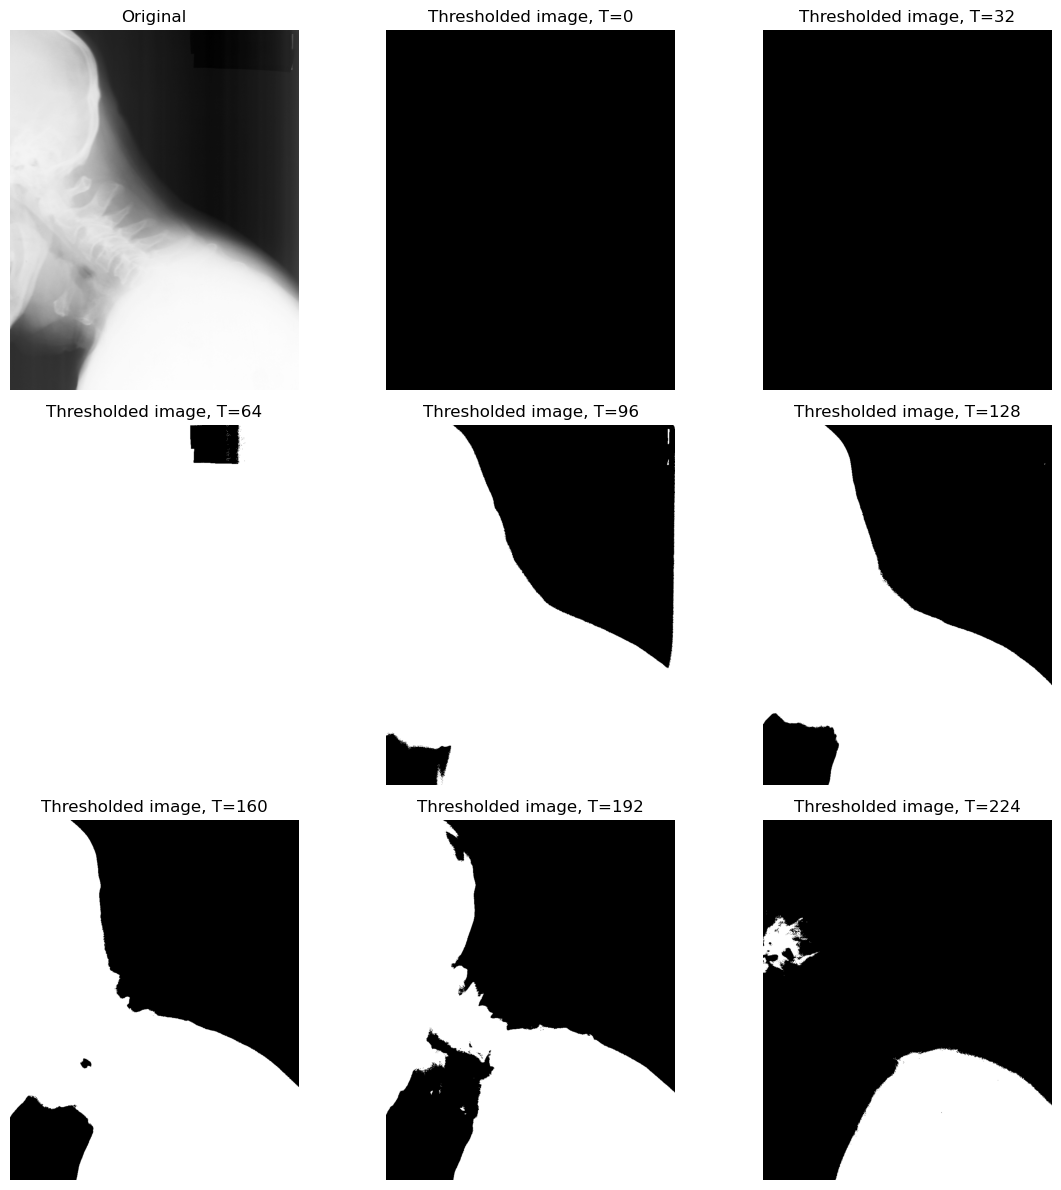

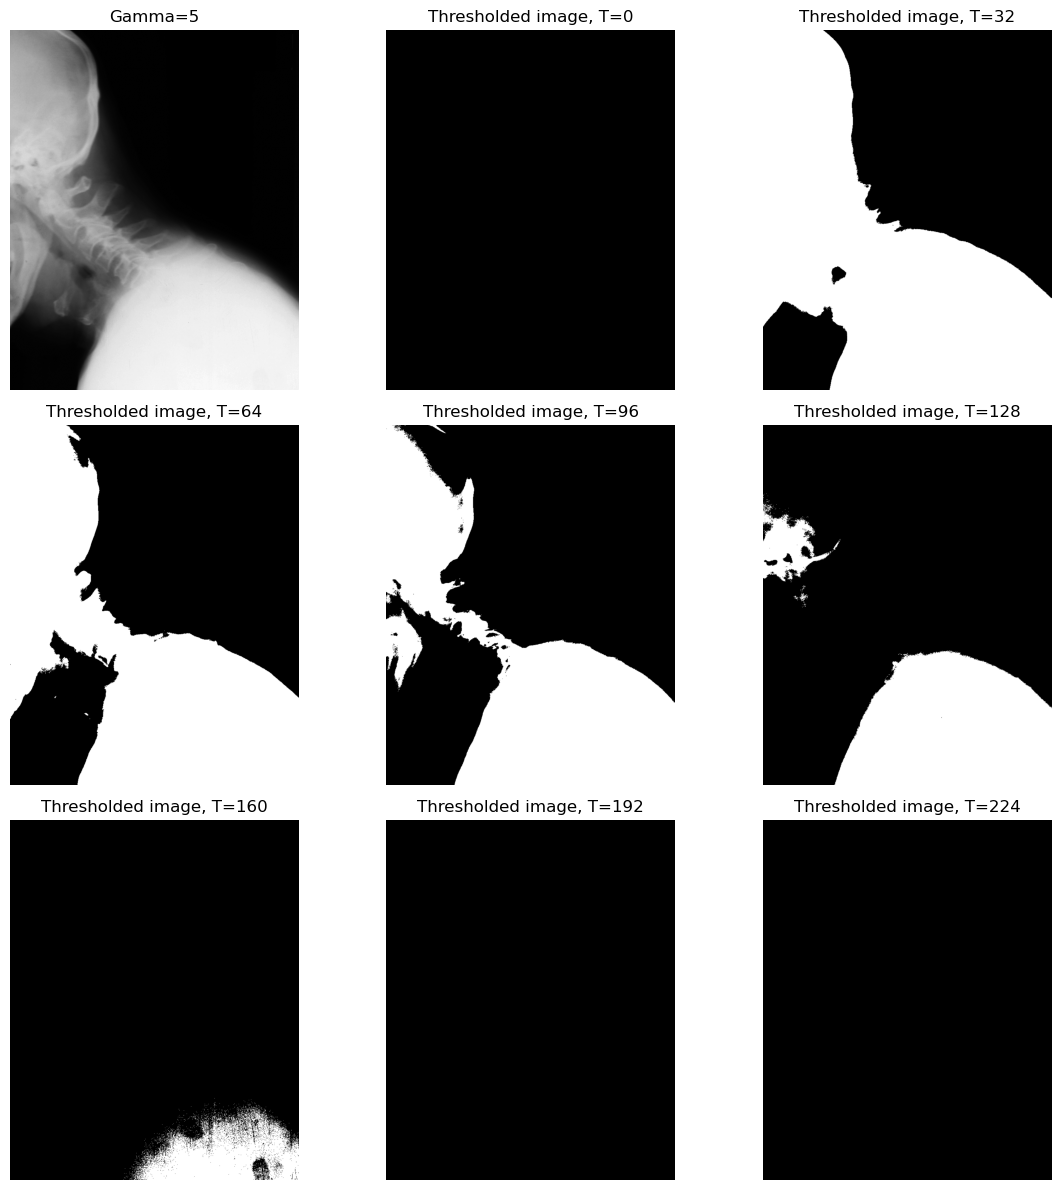

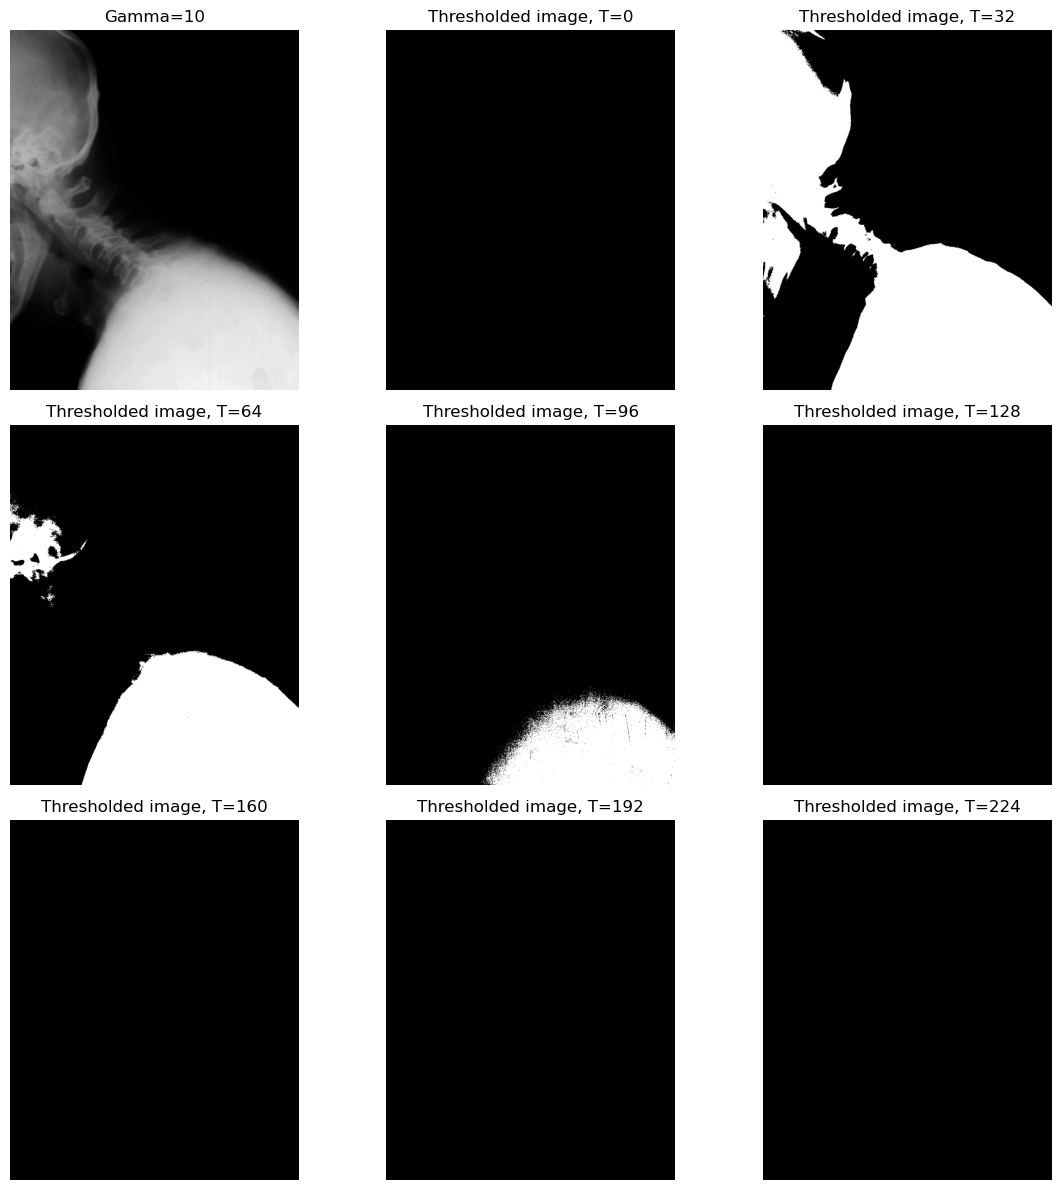

In [88]:
def thresholding(im_org, title, n_images = 8):
    ranges = range(0, 256, int(np.ceil(255/n_images)))
    imt = [threshold_image(im_org, T) for T in ranges]
    titles = ["Thresholded image, T="+str(T) for T in ranges]

    plot_images_grid([im_org, *imt], titles=[title, *titles])
    plt.show()

thresholding(io.imread("vertebra.png"), "Original")
thresholding(gamma_map(io.imread("vertebra.png"), gamma=5), "Gamma=5")
thresholding(gamma_map(io.imread("vertebra.png"), gamma=10), "Gamma=10")


# Exercise 11

We can do it much more effectively than above grids, by using Otsu's method:

In [73]:
from skimage.filters import threshold_otsu

(<Figure size 800x400 with 2 Axes>,
 array([[<Axes: title={'center': 'Original'}>,
         <Axes: title={'center': 'Otsu Thresholded Image (T=148)'}>]],
       dtype=object))

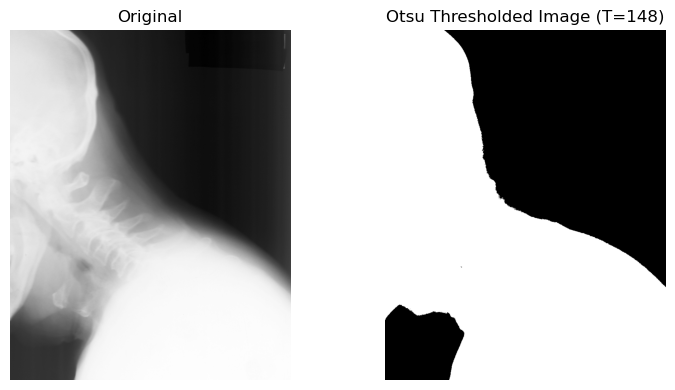

In [ ]:
imt = threshold_image(im:=io.imread("vertebra.png"), T:=threshold_otsu(im))
plot_images_grid([im, imt], ["Original", f"Otsu Thresholded Image (T={T})"])

So to find edges, utilizing Otsu's method is a good choice, but if we want to focus on the bones it is not the best choice.

# Exercise 12

/tmp/ipykernel_63202/1128743436.py:3: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (510, 776, 3) looks like that of an RGB image.
  imt = threshold_image(img, T:=threshold_otsu(im))


(<Figure size 800x400 with 2 Axes>,
 array([[<Axes: title={'center': 'Original'}>,
         <Axes: title={'center': 'Otsu Thresholded Image (T=62)'}>]],
       dtype=object))

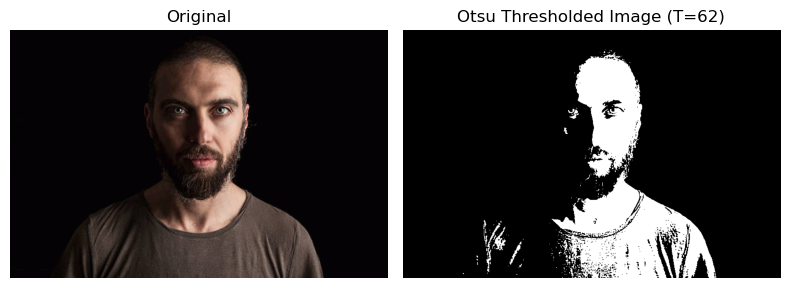

In [82]:
im = io.imread("dark_background.png")
img = rgb2gray(im)
imt = threshold_image(img, T:=threshold_otsu(im))
plot_images_grid([im, imt], ["Original", f"Otsu Thresholded Image (T={T})"])

Alternatively, using our function:

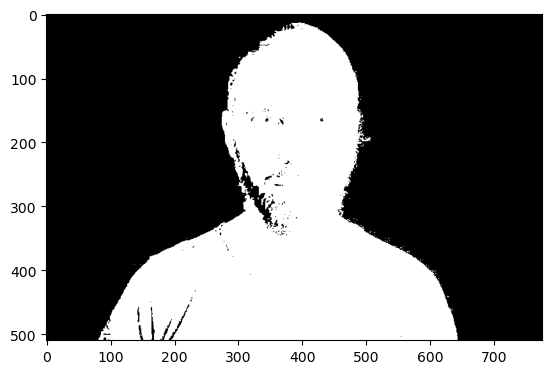

In [99]:
# thresholding(img, "Original", 16)
plt.imshow(threshold_image(img, 6), cmap="gray")

For the expected result, it seems better to use our own searching than utilizing otsu. But the result is still nowhere near perfect.

In [ ]:
def detect_dtu_signs(color_img):
    r_comp = color_img[:, :, 0]
    g_comp = color_img[:, :, 1]
    b_comp = color_img[:, :, 2]
    segm_blue = (r_comp < 10) & (g_comp > 85) & (g_comp < 105) \
        & (b_comp > 180) & (b_comp < 200)
    return segm_blue

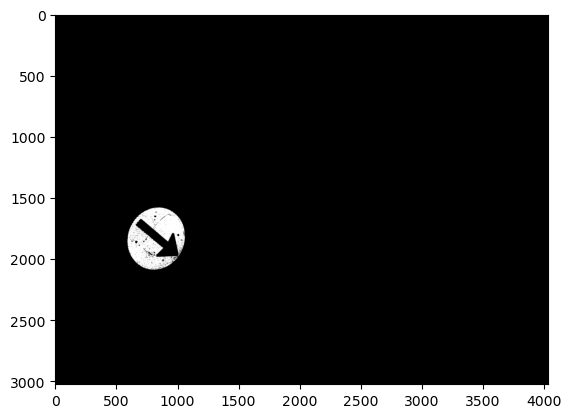

In [105]:
im = io.imread("DTUSigns2.jpg")
plt.imshow(detect_dtu_signs(im), cmap="gray")

In [136]:
def detect_dtu_signs(color_img):
    r_comp = color_img[:, :, 0]
    g_comp = color_img[:, :, 1]
    b_comp = color_img[:, :, 2]
    segm_blue = (r_comp < 10) & \
        (g_comp > 85) & (g_comp < 105) \
        & (b_comp > 180) & (b_comp < 200)
    segm_red = (r_comp > 120) & (r_comp < 191) \
        & (g_comp < 70) & (g_comp > 50)\
        & (b_comp < 70) & (b_comp > 50)
    segm_blue_red = segm_red + segm_blue
    return segm_blue_red

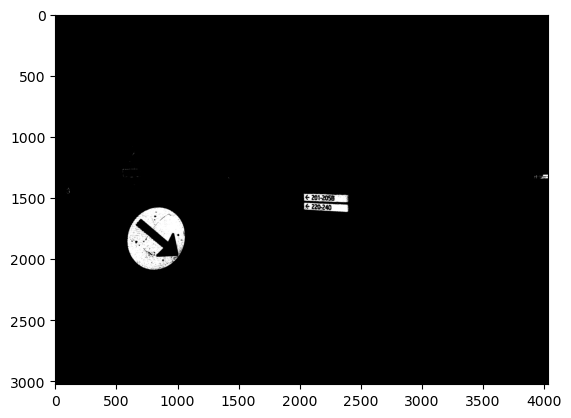

In [137]:
im = io.imread("DTUSigns2.jpg")
plt.imshow(detect_dtu_signs(im), cmap="gray")

I used a color picker to find RGB values for the dtu signs and the red borders on the parking signs. This way I could segment between the two. I created two masks, one for blue signs and one for the red dtu signs and added them together, to create a final mask.

Alternatively, I guess I could separate the image channels and look at histograms to segment the different objects. The red dtu signs would be more prominent than the borders on the parking signs, but I don't think I would capture the darker dtu sign (in background) as well.

# Exercise 15

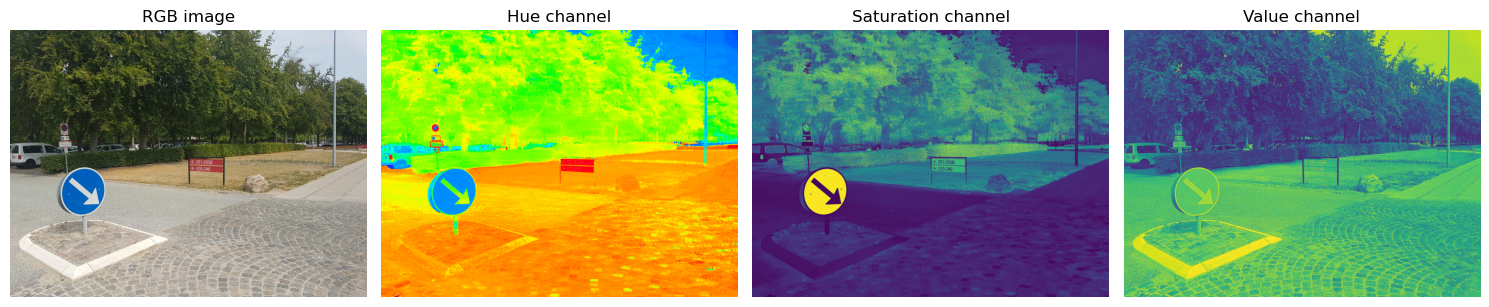

In [ ]:
color_img = io.imread("DTUSigns2.jpg")
hsv_img = color.rgb2hsv(color_img)
hue_img = hsv_img[:, :, 0]
sat_img = hsv_img[:, :, 1]
value_img = hsv_img[:, :, 2]
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(15, 4))
ax0.imshow(color_img)
ax0.set_title("RGB image")
ax0.axis('off')
ax1.imshow(hue_img, cmap='hsv')
ax1.set_title("Hue channel")
ax1.axis('off')
ax2.imshow(sat_img)
ax2.set_title("Saturation channel")
ax2.axis('off')
ax3.imshow(value_img)
ax3.set_title("Value channel")
ax3.axis('off')

fig.tight_layout()
plt.show()

It may seem like it would be hard to differentiate only based on value channel, but hue channel separates the signs and background really well.

In [ ]:
def detect_by_hsv(color_img):
    hsv_img = color.rgb2hsv(color_img)
    hue_img = hsv_img[:, :, 0]
    sat_img = hsv_img[:, :, 1]
    value_img = hsv_img[:, :, 2]

    segm_blue = ()
    segm_red = ()
    segm_blue_red = segm_red + segm_blue
    return segm_blue_red

In [ ]:
im = io.imread("DTUSigns2.jpg")
plt.imshow(detect_by_hsv(im), cmap="gray")